In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!ls /content/drive/MyDrive/ndui

In [3]:
import xarray as xr
import numpy as np
ds_dmsp = xr.open_dataset('/content/drive/MyDrive/ndui/dmsp_2012_austin.nc').constant
ds_viirs = xr.open_dataset('/content/drive/MyDrive/ndui/viirs_2012_austin.nc').avg_rad

In [4]:
x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)

In [5]:
import numpy as np

def unpatchify(patches, img_shape):
    patch_size = patches.shape[1]
    assert patches.shape[0] == (img_shape[0] // patch_size) * (img_shape[1] // patch_size), "Patches and image shape are not compatible"

    img = np.zeros(img_shape, dtype=patches.dtype)
    patch_idx = 0

    for i in range(0, img_shape[0], patch_size):
        for j in range(0, img_shape[1], patch_size):
            img[i:i + patch_size, j:j + patch_size] = patches[patch_idx]
            patch_idx += 1

    return img

def patchify(img, patch_size):
    img_shape = img.shape
    patches = np.array([img[i:i + patch_size, j:j + patch_size] for i in range(0, img_shape[0], patch_size) for j in range(0, img_shape[1], patch_size)])
    return patches

In [6]:
# Create patches from the image
patch_size = 32
img = x_train[:576,:576]
patches = patchify(img, patch_size)

In [7]:
x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:576,:576], patch_size)
y_train_patches = patchify(y_train[:576,:576], patch_size)
x_train_patches.shape

(324, 32, 32)

In [8]:
x_val_patches = x_train_patches[200:300]
y_val_patches = y_train_patches[200:300]

x_test_patches = x_train_patches[300:]
y_test_patches = y_train_patches[300:]

x_train_patches = x_train_patches[:200]
y_train_patches = y_train_patches[:200]

In [9]:
x_test_patches.shape

(24, 32, 32)

In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim

In [11]:
class ncDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = torch.from_numpy(self.data[index]).unsqueeze(0)
        y = torch.from_numpy(self.targets[index]).unsqueeze(0)
        # x = self.data[index]
        # y = self.targets[index]
        # x = x.to(dtype=torch.float32)
        # y = y.to(dtype=torch.float32)
        return x, y

    def __len__(self):
        return len(self.data)

In [12]:
train_dataset = ncDataset(x_train_patches, y_train_patches)
val_dataset = ncDataset(x_val_patches, y_val_patches)
test_dataset = ncDataset(x_val_patches, y_val_patches)

In [13]:
lr, hr = train_dataset.__getitem__(0)
print(lr.shape, hr.shape, train_dataset.__len__())

torch.Size([1, 32, 32]) torch.Size([1, 32, 32]) 200


In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

In [15]:
for batch in train_dataloader:
    data, targets = batch
    print(data.size())  # Should print torch.Size([16, 1, 30, 30])
    print(targets.size())  # Should print torch.Size([16, 1, 30, 601])
    break

torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])


In [16]:
import torch
from diffusers import UNet2DModel, EDMEulerScheduler
from torch.optim import Adam
from tqdm import tqdm
# from datasets import load_dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import numpy as np

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [19]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [20]:
class_emb_size = 1
device = 'cuda'
# model = UNet2DModel(
#     sample_size=32,  # Target image resolution
#     in_channels=1 + class_emb_size,  # Additional input channels for class conditioning
#     out_channels=1,  # Number of output channels
#     layers_per_block=2,  # Number of ResNet layers per UNet block

#     # Ensure block_out_channels matches the number of down_block_types
#     block_out_channels=(64, 128, 256, 512),

#     down_block_types=(
#         "DownBlock2D",  # Regular ResNet downsampling block
#         "AttnDownBlock2D",  # Spatial self-attention downsampling block
#         "AttnDownBlock2D",
#         "DownBlock2D",  # Additional down block
#     ),

#     up_block_types=(
#         "UpBlock2D",
#         "AttnUpBlock2D",
#         "AttnUpBlock2D",  # More attention layers
#         "UpBlock2D",
#     ),
# ).to(device)


model = UNet2DModel(
        sample_size=32,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    ).to(device)

In [21]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [22]:
!pip install wandb

In [23]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =25

wandb.init(project="diffusion_test", name="ddpm", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manmeet3591 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [24]:
# How many runs through the data should we do?
n_epochs =25


# Our loss function
loss_fn = nn.MSELoss()

# # The optimizer
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# Optimizer: Use AdamW
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)


# Early stopping parameters
early_stopping_patience = 5000  # Stop if no improvement after 10 epochs
best_val_loss = float("inf")
patience_counter = 0
print_step = 1


# The training loop
for epoch in range(n_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        input, targets = batch
        x = input.to(device)  # Data on the GPU (mapped to (-1, 1))
        y = targets.to(device)
        noise = torch.randn_like(y)
        timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
        noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
        bs, ch, w, h = y.shape
        net_input = torch.cat((noisy_y, x), 1) # (bs, 2, 28, 28)
        pred = model(net_input, timesteps).sample
        loss = loss_fn(pred, noise) # How close is the output to the noise
        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()

        # Store the loss for later
        losses.append(loss.item())
        # Print loss every 100 steps

    avg_train_loss = sum(losses)/len(losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x = input.to(device)
            y = targets.to(device)
            noise = torch.randn_like(y)
            timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(device)
            noisy_y = noise_scheduler.add_noise(y, noise, timesteps)
            net_input = torch.cat((noisy_y, x), 1)
            pred = model(net_input, timesteps).sample
            loss = loss_fn(pred, noise)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": scheduler.get_last_lr()[0]
    })

    if epoch % print_step == 0:
            # print(f"Epoch {epoch}, Step {step}, Training Loss: {loss.item():.6f}")
        print(f"Epoch {epoch}: Avg Train Loss: {avg_train_loss:.6f}, Avg Val Loss: {avg_val_loss:.6f}")

    # Checkpoint: Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping condition
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Epoch 0: Avg Train Loss: 0.677096, Avg Val Loss: 0.398206
Saved best model!
Epoch 1: Avg Train Loss: 0.282712, Avg Val Loss: 0.190675
Saved best model!
Epoch 2: Avg Train Loss: 0.166620, Avg Val Loss: 0.170898
Saved best model!
Epoch 3: Avg Train Loss: 0.127462, Avg Val Loss: 0.128485
Saved best model!
Epoch 4: Avg Train Loss: 0.104853, Avg Val Loss: 0.101480
Saved best model!
Epoch 5: Avg Train Loss: 0.095401, Avg Val Loss: 0.104397
Early stopping patience: 1/5000
Epoch 6: Avg Train Loss: 0.099062, Avg Val Loss: 0.100367
Saved best model!
Epoch 7: Avg Train Loss: 0.092552, Avg Val Loss: 0.083157
Saved best model!
Epoch 8: Avg Train Loss: 0.085533, Avg Val Loss: 0.079352
Saved best model!
Epoch 9: Avg Train Loss: 0.081996, Avg Val Loss: 0.087047
Early stopping patience: 1/5000
Epoch 10: Avg Train Loss: 0.067193, Avg Val Loss: 0.072450
Saved best model!
Epoch 11: Avg Train Loss: 0.064138, Avg Val Loss: 0.071745
Saved best model!
Epoch 12: Avg Train Loss: 0.065544, Avg Val Loss: 0.065003

In [25]:
# Load the trained model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

for batch in test_dataloader:
    lr, hr = batch
    lr, hr = lr.to(device), hr.to(device)
    noise = torch.randn_like(hr)
    pred = noise.clone()
    net_input = torch.cat((noise, lr), 1)
    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

        # Get model pred
        with torch.no_grad():
            residual = model(net_input, t).sample  # Extract .sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample  # Correct attribute usage

<ipython-input-25-986cc1987f4f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [26]:
x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:512,:512]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)

pred_patches = []
for batch in x_train_patches_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)

    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(512, 512)

In [28]:
lats = ds_dmsp.y.values[:512]
lons = ds_dmsp.x.values[:512]
dmsp_ = ds_dmsp.values[0,:512,:512]

In [29]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_ddpm': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:512,:512],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

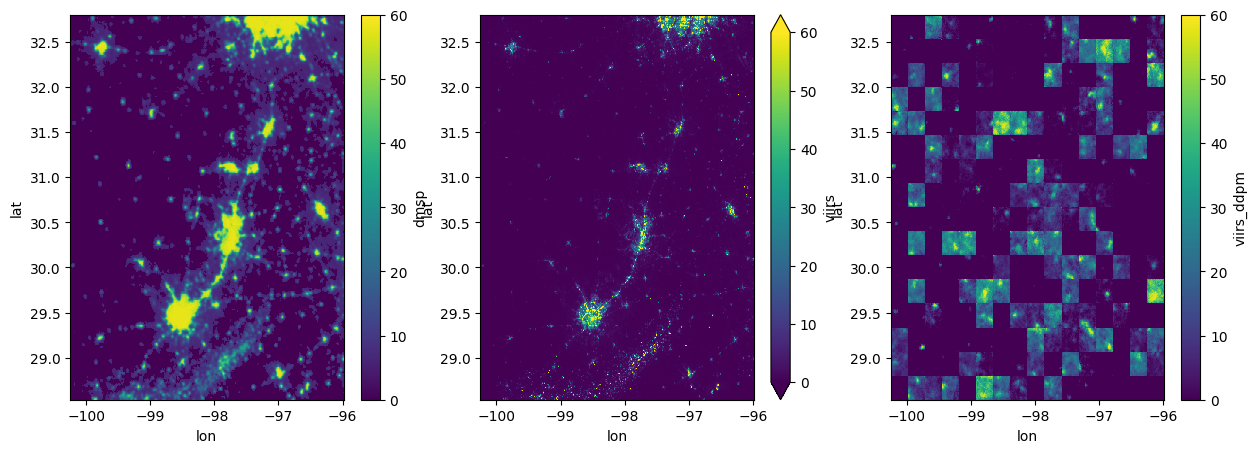

In [30]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_ddpm.plot(ax=ax[2], vmax=60)

# Without Patches

In [ ]:
x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

# x_train_patches = patchify(x_train[:512,:512], patch_size)[:,np.newaxis,:,:]
# x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)
pred_patches = []
for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    print(batch.shape)
    noise = torch.randn_like(batch)
    pred = noise.clone()
    net_input = torch.cat((pred, batch), 1)
    print(net_input.shape)
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling steps"):
        with torch.no_grad():
            residual = model(net_input, t).sample
        pred = noise_scheduler.step(residual, t, pred).prev_sample
        net_input = torch.cat((pred, batch), 1)

    pred_patches.append(pred.cpu().numpy())

predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

torch.Size([1, 1, 576, 576])
torch.Size([1, 2, 576, 576])


Sampling steps:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

In [ ]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [ ]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_ddpm': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:512,:512],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_ddpm.plot(ax=ax[2], vmax=60)

# EDM Diffusion

In [ ]:
from diffusers import EDMEulerScheduler

# Initialize the EDMEulerScheduler with EDM parameters
noise_scheduler = EDMEulerScheduler(
    sigma_min=0.002,          # Minimum noise level (as in the EDM paper)
    sigma_max=80.0,           # Maximum noise level (as in the EDM paper)
    sigma_data=0.5,           # Standard deviation of the data distribution
    sigma_schedule="karras",  # Use the Karras sigma schedule
    num_train_timesteps=1000, # Number of diffusion timesteps used during training
    prediction_type="epsilon",# Prediction type ('epsilon' is standard)
    rho=7.0                   # Rho parameter used in the Karras schedule
)